In [ ]:
# Check GPU
!nvidia-smi --query-gpu=name --format=csv,noheader

NVIDIA L4


In [ ]:
!pip install -U bitsandbytes
!pip install -q transformers accelerate bitsandbytes torch
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-z3_4rm1c
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-z3_4rm1c
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import re
import urllib
from google.colab import userdata  # Import Colab secrets
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import json
import numpy as np
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg") # test image
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
img = Image.open(filename)

In [ ]:
# Authenticate with  token
hf_token = userdata.get('HF_TOKEN')  # Retrieves token --> Assuming that everyone needs to make their own hugging face account?

# Load model with authentication
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
llm_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    token=hf_token,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16
    ),
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#Test that the loading worked

def generate_response(prompt, max_new_tokens=50):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = llm_model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


PROMPTING

In [ ]:
# perturbations_prompt = "Give locations, size, and type of perturbations to be done to an image. The image size is 1920 by 1080 and the maximum perturbation size is 100 by 100. Give a list of 10 perturbations which specify pixel location, size of the perturbation patch, channel an integer between 0 and 3, and type of perturbation. Respond only in JSON format with no explainations."

# perturbation_examples = """  {"location": [20, 30], "size": [10, 10], "channel": 0, "type": "gaussian_noise"},
#   {"location": [50, 60], "size": [8, 8], "channel": 0, "type": "blur"},
#   {"location": [70, 20], "size": [6, 6], "channel": 1, "type": "occlusion"},
#   {"location": [10, 10], "size": [9, 9], "channel": 2, "type": "brightness_increase"},
#   {"location": [80, 40], "size": [7, 7], "channel": 0, "type": "contrast_decrease"},
#   {"location": [30, 70], "size": [10, 10], "channel": 1, "type": "salt_and_pepper_noise"},
#   {"location": [60, 15], "size": [5, 5], "channel": 2, "type": "motion_blur"},
#   {"location": [25, 85], "size": [6, 6], "channel": 1, "type": "color_shift"},
#   {"location": [90, 90], "size": [10, 10], "channel": 2, "type": "sharpen"},
#   {"location": [40, 50], "size": [7, 7], "channel": 0, "type": "grayscale"}
#   """

# ranks = [0.9,1,0.2,0.3,0.1,0.5,0,0.2,0.2,0.8]



In [ ]:
perturbations_prompt = "Give types of perturbations to be done to an image. The image size is 256 by 256.\
Give a list of up to 10 perturbations where operations are one of these: [rotate, adjust_brightness, blur_patch, add_stripe_noise, add_patch, translate].\
Rotate requires an angle parameter.\
adjust_brightness requires a factor parameter.\
blur_patch requires center, radius, and sigma parameters.\
add_stripe_noise requires orientation, stripe_width, intensity, and location.\
add_patch requires location, size, and type parameters with an option color parameter.\
translate requires x_shift and y_shift parameters.\
Respond only in JSON format with no explainations."

perturbation_examples = """
    [{
            "operation": "rotate",
            "angle": 15
    },
    {
            "operation": "adjust_brightness",
            "factor": 1.5
    },
    {
            "operation": "blur_patch",
            "center": [80, 60],
            "radius": 20,
            "sigma": 5.0
    },
    {
            "operation": "add_stripe_noise",
            "orientation": "horizontal",
            "stripe_width": 10,
            "intensity": 0.1,
            "location": 0.3
    },
    {
            "operation": "add_patch",
            "location": [50, 50],
            "size": [40, 40],
            "type": "noise"
    },
    {
            "operation": "add_patch",
            "location": [120, 120],
            "size": [30, 30],
            "type": "color",
            "color": [255, 0, 0]
    },
    {
            "operation": "translate",
            "x_shift": 20,
            "y_shift": 30
    }]"""

In [ ]:
def generate_new_perturbations_prompt(prev_pert = perturbation_examples, ranks = [], size = [256,256]):
  perturbations_prompt = f"Give types of perturbations to be done to an image. The image size is {size[0]} by {size[1]}.\
Give a list of up to 10 perturbations where operations are one of these: [rotate, adjust_brightness, blur_patch, add_stripe_noise, add_patch, translate].\
Rotate requires an angle parameter.\
adjust_brightness requires a factor parameter.\
blur_patch requires center, radius, and sigma parameters.\
add_stripe_noise requires orientation, stripe_width, intensity, and location.\
add_patch requires location, size, and type parameters with an option color parameter.\
translate requires x_shift and y_shift parameters.\
Respond only in JSON format with no explainations."
  if ranks == []:
    prompt = perturbations_prompt + " Examples: " + prev_pert + "Generate new perturbations, only using JSON \n"
  else:
    prompt = perturbations_prompt + " Previous responses: " + prev_pert + " Scored between 0 and infinite where 0 is better: " + str(ranks) + " \nGenerate new perturbations without explanations, only using JSON \n"
  return prompt

In [ ]:
test = generate_new_perturbations_prompt()
print(test)

Give types of perturbations to be done to an image. The image size is 256 by 256.Give a list of up to 10 perturbations where operations are one of these: [rotate, adjust_brightness, blur_patch, add_stripe_noise, add_patch, translate].Rotate requires an angle parameter.adjust_brightness requires a factor parameter.blur_patch requires center, radius, and sigma parameters.add_stripe_noise requires orientation, stripe_width, intensity, and location.add_patch requires location, size, and type parameters with an option color parameter.translate requires x_shift and y_shift parameters.Respond only in JSON format with no explainations. Examples: 
    [{
            "operation": "rotate",
            "angle": 15
    },
    {
            "operation": "adjust_brightness",
            "factor": 1.5
    },
    {
            "operation": "blur_patch",
            "center": [80, 60],
            "radius": 20,
            "sigma": 5.0
    },
    {
            "operation": "add_stripe_noise",
         

In [ ]:
## Select only the json list from the response
def extract_text_between_brackets(text):
  text = text.split("only using JSON \n")[1] # Ignore example json list
  text = text.replace(' ', '')
  text = text.replace('\n', '')
  text = text.replace('\\','')
  if len(re.findall(r"\[\{(.*?)\}\]", text, re.DOTALL)) == 0: # If no full JSON exists return empty list
    return "[]"
  return "[{"+re.findall(r"\[\{(.*?)\}\]", text, re.DOTALL)[0]+"}]"

In [ ]:
response = generate_response(test, 400)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [ ]:
print(extract_text_between_brackets(response))
commands = json.loads(extract_text_between_brackets(response))

[{"operation":"rotate","angle":25},{"operation":"adjust_brightness","factor":0.5},{"operation":"blur_patch","center":[100,150],"radius":25,"sigma":3.5},{"operation":"add_stripe_noise","orientation":"vertical","stripe_width":15,"intensity":0.2,"location":0.5},{"operation":"add_patch","location":[90,90],"size":[50,50],"type":"noise"},{"operation":"add_patch","location":[140,140],"size":[20,20],"type":"color","color":[0,255,0]},{"operation":"translate","x_shift":15,"y_shift":20}]


PERTURBATOR

In [ ]:
def rotate_image(image, angle):
    return image.rotate(angle)

def adjust_brightness(image, factor):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

def blur_patch(image, center, radius, sigma):
    img_np = np.array(image)
    (h, w, _) = img_np.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    cv2.circle(mask, tuple(center), radius, 255, -1)

    blurred = cv2.GaussianBlur(img_np, (0, 0), sigma)

    mask = mask[:, :, np.newaxis] / 255.0
    output = img_np * (1 - mask) + blurred * mask
    output = np.clip(output, 0, 255).astype(np.uint8)

    return Image.fromarray(output)

def add_stripe_noise(image, orientation, stripe_width, intensity, location=0):
    img_np = np.array(image).astype(np.float32) / 255.0
    noise = np.random.uniform(-intensity, intensity, img_np.shape)

    mask = np.zeros_like(img_np)
    H, W, _ = img_np.shape

    if orientation == "horizontal":
        # Horizontal stripe centered at given y-location
        y_center = int(location * H)
        y_start = max(0, y_center - stripe_width // 2)
        y_end = min(H, y_center + stripe_width // 2)
        mask[y_start:y_end, :, :] = 1
    elif orientation == "vertical":
        # Vertical stripe centered at given x-location
        x_center = int(location * W)
        x_start = max(0, x_center - stripe_width // 2)
        x_end = min(W, x_center + stripe_width // 2)
        mask[:, x_start:x_end, :] = 1

    noisy_img = np.clip(img_np + noise * mask, 0, 1)
    noisy_img = (noisy_img * 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

def add_patch(image, location, size, type_="noise", color=None):
    img_np = np.array(image)

    patch = None
    if type_ == "noise":
        patch = np.random.randint(0, 256, (size[1], size[0], 3), dtype=np.uint8)
    elif type_ == "color" and color is not None:
        patch = np.ones((size[1], size[0], 3), dtype=np.uint8) * np.array(color, dtype=np.uint8)

    x, y = location  # Now input is exact (x, y)

    # Boundary check
    H, W, _ = img_np.shape
    x = max(0, min(x, W - size[0]))
    y = max(0, min(y, H - size[1]))

    img_np[y:y+size[1], x:x+size[0]] = patch

    return Image.fromarray(img_np)

def translate_image(image, x_shift, y_shift):
    img_np = np.array(image)
    (h, w) = img_np.shape[:2]

    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    shifted = cv2.warpAffine(img_np, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    return Image.fromarray(shifted)


In [ ]:
def apply_action(image, action_dict):
    operation = action_dict["operation"]

    if operation == "rotate":
        return rotate_image(image, angle=action_dict["angle"])
    elif operation == "adjust_brightness":
        return adjust_brightness(image, factor=action_dict["factor"])
    elif operation == "blur_patch":
        return blur_patch(
            image,
            center=action_dict["center"],
            radius=action_dict["radius"],
            sigma=action_dict["sigma"]
        )
    elif operation == "add_stripe_noise":
        return add_stripe_noise(
            image,
            orientation=action_dict["orientation"],
            stripe_width=action_dict["stripe_width"],
            intensity=action_dict["intensity"],
            location=action_dict.get("location", 0)
        )
    elif operation == "add_patch":
        return add_patch(
            image,
            location=action_dict["location"],
            size=action_dict["size"],
            type_=action_dict.get("type", "noise"),
            color=action_dict.get("color")
        )
    elif operation == "translate":
        return translate_image(
            image,
            x_shift=action_dict["x_shift"],
            y_shift=action_dict["y_shift"]
        )
    else:
        raise ValueError(f"Unknown operation: {operation}")


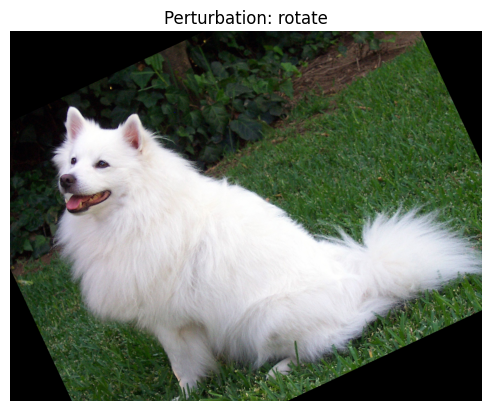

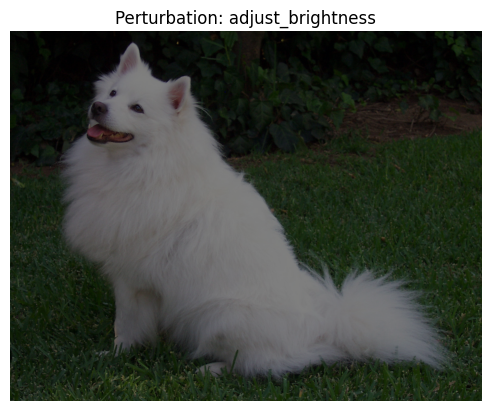

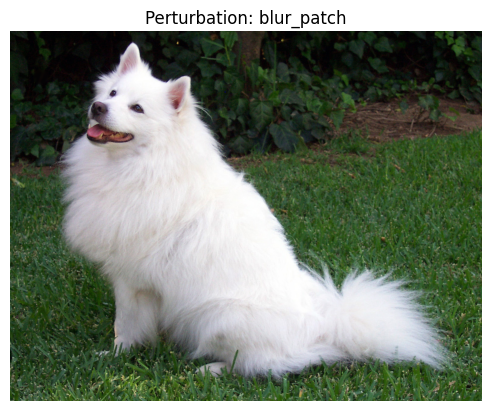

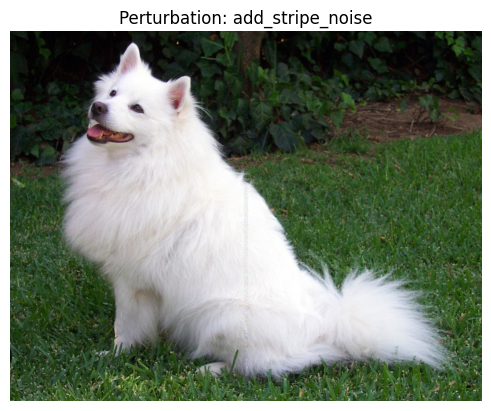

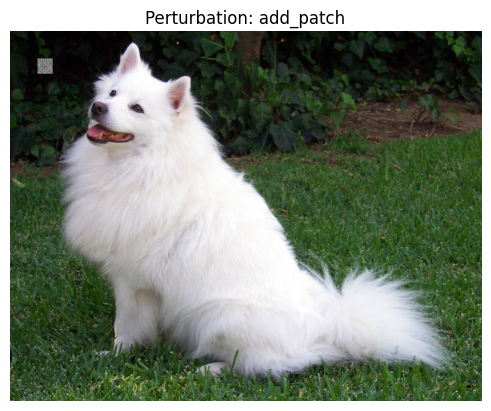

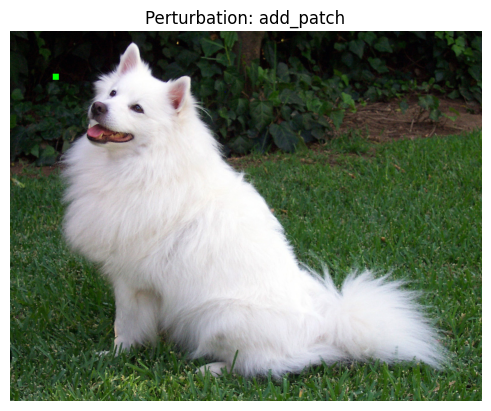

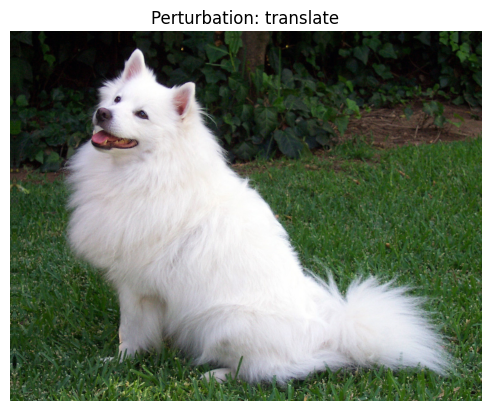

In [ ]:
def show_image(image, title="Image"):
    plt.imshow(np.array(image))
    plt.title(title)
    plt.axis('off')
    plt.show()

for command in commands:
  perturbed_img = apply_action(img, command)
  show_image(perturbed_img, title=f"Perturbation: {command['operation']}")

RESNET

In [ ]:
resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2025-05-09 16:31:29--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.3’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-05-09 16:31:29 (128 MB/s) - ‘imagenet_classes.txt.3’ saved [10472/10472]



In [ ]:
def classify_image(image):
  # sample execution (requires torchvision)

  # resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True) # move outside so it doesn't need to be loaded multiple times

  input_image = image
  preprocess = transforms.Compose([ # Could maybe do this preprocessing in a single pass on all the images before starting the epochs.
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      resnet_model.to('cuda')

  with torch.no_grad():
      output = resnet_model(input_batch)
  # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
  # print(output[0])
  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  # print(probabilities)

  # Read the categories
  with open("imagenet_classes.txt", "r") as f:
      categories = [s.strip() for s in f.readlines()]
  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  # for i in range(top5_prob.size(0)):
  #     print(categories[top5_catid[i]], top5_prob[i].item())

  # Return top prediction
  return categories[top5_catid[0]], top5_prob[0].item(), probabilities

In [ ]:
c, s, probabilities = classify_image(img)

In [ ]:
c

'Samoyed'

CLIP SIMILARITY

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
def image_distance(image1, image2):
  # model, preprocess = clip.load("ViT-B/32", device=device) # Likely move this line out of function so it doesn't have to keep reloading
  cos = torch.nn.CosineSimilarity(dim=0)

  image1_preprocess = clip_preprocess(image1).unsqueeze(0).to(device)
  image1_features = clip_model.encode_image( image1_preprocess)

  image2_preprocess = clip_preprocess(image2).unsqueeze(0).to(device)
  image2_features = clip_model.encode_image( image2_preprocess)

  similarity = cos(image1_features[0],image2_features[0]).item()
  return 1 - (similarity+1)/2


def image_distance2(image1, image2):
  if image1.shape != image2.shape:
      raise ValueError("Images must have the same shape")
  return np.linalg.norm(image1.astype(float) - image2.astype(float))


In [ ]:
similarity_score = image_distance(img, perturbed_img)
similarity_score

0.9970703125

LOSS

In [ ]:
def loss_func(label, probabilities, similarity):
  c = torch.tensor([0.5], device=device) # Hyperparameter
  loss = torch.nn.CrossEntropyLoss()
  loss = loss(label, probabilities)
  return loss - similarity * c

In [ ]:
one_hot_encoding_of_label = torch.zeros(1000, device=device)
one_hot_encoding_of_label[probabilities.argmax()] = 1
loss_func(one_hot_encoding_of_label, probabilities, similarity_score)

tensor([5.5262], device='cuda:0')

SUDO CODE FOR POSSIBLE EXECUTION CYCLE?

In [ ]:
# Preprocessing to get images that resnet classifies correctly

# prompt = generate_new_perturbations_prompt() ##First Pass
# for epochs
#   for image, label in images: Should probably be in batch form...
#     response = generate_response(prompt, 400) ##First Pass
#     json_list = extract_text_between_brackets(response) ##Done
#     new_image = perturbator(image, json_list) ##Done
#     _, _, probabilities = classify_image(new_image) ##Done
#     similarity_score = image_distance(image, new_image) ##Done
#     loss = loss_func(label, probabilities, similarity_score) ##Done
#     prompt = generate_new_perturbations_prompt(json_list, loss) ##First Pass

In [ ]:
valid_operations = ['rotate', 'adjust_brightness', 'blur_patch', 'add_stripe_noise', 'add_patch', 'translate']
epochs = 3
prompt = generate_new_perturbations_prompt(size=img.size) # If we use all images of the same size can set the size = to that
for i in range(epochs):
  print(f"STARTING EPOCH: {i}")
  #for image, label in image_dataset: # Use this once we have a dataset

  img = Image.open(filename)

  c, s, probabilities = classify_image(img) # Replace these lines with the proper label from dataset
  one_hot_encoding_of_label = torch.zeros(1000, device=device)
  one_hot_encoding_of_label[probabilities.argmax()] = 1
  label = one_hot_encoding_of_label

  response = generate_response(prompt, 400)
  json_list = json.loads(extract_text_between_brackets(response))
  perturbed_img = img
  loss = float('inf')
  if json_list != "[]":
    remove_indices = []
    for command in json_list:
      if 'operation' in command.keys() and command['operation'] in valid_operations:
        try:
          perturbed_img = apply_action(perturbed_img, command)
          # show_image(perturbed_img, title=f"Perturbation: {command['operation']}") # For seeing the operations occur
        except:
          print(f"Error in operation: {command['operation']}")
          print(command)
          remove_indices.append(json_list.index(command))
      else:
        print(f"Illegal operation or format: {command}")
        remove_indices.append(json_list.index(command))
    c, s, probabilities = classify_image(perturbed_img)
    similarity_score = image_distance(img, perturbed_img)
    loss = loss_func(label, probabilities, similarity_score)
    json_list = [json_list[i] for i in range(len(json_list)) if i not in remove_indices] # Don't feed error examples back (Might want to instead feed them as "Bad" examples)
  print(f"Loss: {loss}")
  prompt = generate_new_perturbations_prompt(json.dumps(json_list), loss, img.size)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


STARTING EPOCH: 0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Loss: tensor([5.6581], device='cuda:0')
STARTING EPOCH: 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Loss: tensor([5.9183], device='cuda:0')
STARTING EPOCH: 2
Loss: tensor([6.3238], device='cuda:0')


# Fine Tune Pre-trained ResNet18 Image Classifier

In [ ]:
# Load previously fine-tuned model

# Initialize dataloaders


